In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_35000 = pd.read_excel("35000.xlsx")
data_1400 = pd.read_excel("1400.xlsx")

In [3]:
data_35000.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [4]:
data_1400.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0


### Обрежем данные по IC50 до 250 для очистки данных от разбросов и комментария о том, что на больших значениях эксперименты уже не проводятся

In [5]:
data_35000 = data_35000[data_35000["IC50"] < 250].reset_index(drop=True)
data_1400 = data_1400[data_1400["IC50, mmg/ml"] < 250].reset_index(drop=True)

In [6]:
def mol_dsc_calc(mols):
    return pd.DataFrame(Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(m)) for m in mols)

### Создадим таблицу со всеми возомжным дескрипторами из бибилотеки rdkit для каждого соединения

In [7]:
descriptor_transformer = FunctionTransformer(mol_dsc_calc)
X_35000 = descriptor_transformer.transform(data_35000['SMILES'])
X_1400 = descriptor_transformer.transform(data_1400['SMILES'])

[13:33:01] Conflicting single bond directions around double bond at index 55.
[13:33:01]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:36:59] Conflicting single bond directions around double bond at index 7.
[13:36:59]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:37:08] Conflicting single bond directions around double bond at index 55.
[13:37:08]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [8]:
X_35000.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.743425,11.743425,0.061289,-4.487931,0.216971,362.367,335.151,362.171907,138,0,...,0,0,0,0,0,0,0,0,0,0
1,11.324462,11.324462,0.124444,-0.959020,0.651957,298.383,272.175,298.189257,120,0,...,0,0,0,0,0,0,0,0,0,0
2,11.521766,11.521766,0.025290,-1.252691,0.624022,295.359,272.175,295.166331,118,0,...,0,0,0,0,0,0,0,0,0,0
3,11.271766,11.271766,0.000752,-1.236230,0.681758,283.348,260.164,283.166331,114,0,...,0,0,0,0,0,0,0,0,0,0
4,11.745432,11.745432,0.243422,-1.443615,0.561612,329.268,318.180,329.064785,122,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_1400.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.803737,8.803737,0.185194,0.185194,0.719980,195.306,174.138,195.162314,80,0,...,0,0,0,0,0,0,0,0,0,0
1,8.803737,8.803737,0.185194,0.185194,0.719980,195.306,174.138,195.162314,80,0,...,0,0,0,0,0,0,0,0,0,0
2,4.983958,4.983958,0.389807,0.389807,0.727487,250.430,220.190,250.240899,104,0,...,0,0,0,0,0,0,0,0,0,0
3,4.888403,4.888403,0.392837,0.392837,0.716719,222.376,196.168,222.209599,92,0,...,0,0,0,0,0,0,0,0,0,0
4,11.775123,11.775123,0.079097,-0.079097,0.707806,239.359,214.159,239.188529,98,0,...,0,0,0,0,0,0,0,0,0,0


### Дропнем все NaN значения из таблицы для большей корректности

In [10]:
idx_35000 = X_35000.index[X_35000.isna().any(axis=1)]
X_35000 = X_35000.drop(idx_35000, axis=0)
X_35000 = X_35000.reset_index(drop=True)
X_35000.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.743425,11.743425,0.061289,-4.487931,0.216971,362.367,335.151,362.171907,138,0,...,0,0,0,0,0,0,0,0,0,0
1,11.324462,11.324462,0.124444,-0.959020,0.651957,298.383,272.175,298.189257,120,0,...,0,0,0,0,0,0,0,0,0,0
2,11.521766,11.521766,0.025290,-1.252691,0.624022,295.359,272.175,295.166331,118,0,...,0,0,0,0,0,0,0,0,0,0
3,11.271766,11.271766,0.000752,-1.236230,0.681758,283.348,260.164,283.166331,114,0,...,0,0,0,0,0,0,0,0,0,0
4,11.745432,11.745432,0.243422,-1.443615,0.561612,329.268,318.180,329.064785,122,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
idx_1400 = X_1400.index[X_1400.isna().any(axis=1)]
X_1400 = X_1400.drop(idx_1400, axis=0)
X_1400 = X_1400.reset_index(drop=True)
X_1400.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.803737,8.803737,0.185194,0.185194,0.719980,195.306,174.138,195.162314,80,0,...,0,0,0,0,0,0,0,0,0,0
1,8.803737,8.803737,0.185194,0.185194,0.719980,195.306,174.138,195.162314,80,0,...,0,0,0,0,0,0,0,0,0,0
2,4.983958,4.983958,0.389807,0.389807,0.727487,250.430,220.190,250.240899,104,0,...,0,0,0,0,0,0,0,0,0,0
3,4.888403,4.888403,0.392837,0.392837,0.716719,222.376,196.168,222.209599,92,0,...,0,0,0,0,0,0,0,0,0,0
4,11.775123,11.775123,0.079097,-0.079097,0.707806,239.359,214.159,239.188529,98,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_35000 = data_35000["IC50"]
y_35000 = y_35000.drop(idx_35000, axis=0)
y_35000 = y_35000.reset_index(drop=True)
y_35000 = y_35000.to_numpy()
y_35000

array([1.45000e-05, 1.59000e-05, 3.34000e-05, ..., 2.45340e+02,
       2.47494e+02, 2.47752e+02])

In [13]:
y_1400 = data_1400["IC50, mmg/ml"]
y_1400 = y_1400.drop(idx_1400, axis=0)
y_1400 = y_1400.reset_index(drop=True)
y_1400 = y_1400.to_numpy()
y_1400

array([2.7, 0.7, 9.9, ..., 0.3, 0.7, 0.1])

In [14]:
X_train_35000, X_test_35000, y_train_35000, y_test_35000 = train_test_split(X_35000, y_35000, test_size=0.3)
scaler_35000 = StandardScaler()
X_train_35000 = scaler_35000.fit_transform(X_train_35000)
X_test_35000 = scaler_35000.transform(X_test_35000)

In [15]:
X_train_1400, X_test_1400, y_train_1400, y_test_1400 = train_test_split(X_1400, y_1400, test_size=0.3)
scaler_1400 = StandardScaler()
X_train_1400 = scaler_1400.fit_transform(X_train_1400)
X_test_1400 = scaler_1400.transform(X_test_1400)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
def random_forest(X_train, y_train):
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)

    return forest

def grad_boost_model(X_train, y_train):
    grad_boost = GradientBoostingRegressor(random_state=0)
    grad_boost.fit(X_train, y_train)

    return grad_boost

In [18]:
n_feautures = 209
n_hidden_1 = 150
n_hidden_2 = 50
n_hidden_3 = 10
learning_rate = 0.001
batch_size = 30

In [19]:
class NN(nn.Module):
    def __init__(self, n_feature, n_hidden_1, n_hidden_2, n_hidden_3):
        super(NN, self).__init__()
        self.l_1 = nn.Linear(n_feature, n_hidden_1)
        self.l_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.l_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.l_4 = nn.Linear(n_hidden_3, 1)

    def forward(self, x):
        x = x.to(torch.float32)
        x = F.gelu(self.l_1(x))
        x = F.gelu(self.l_2(x))
        x = F.gelu(self.l_3(x))
        x = self.l_4(x)
        return x
    
def NN_model(X_train, X_test, y_train, y_test, log_interval):
    X_train = torch.from_numpy(X_train).to(torch.float32)
    X_test = torch.from_numpy(X_test).to(torch.float32)
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)

    model = NN(n_feautures, n_hidden_1, n_hidden_2, n_hidden_3)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_data = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    def train(epoch, loss_vector, log_interval=log_interval):
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = torch.sqrt(criterion(output, target.unsqueeze(1)))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_loss += loss.data.item()

            if batch_idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )

        loss_vector.append(train_loss / len(train_loader))

    def test(loss_vector):
        model.eval()  # Set model to evaluation mode
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = torch.sqrt(criterion(output, target.unsqueeze(1)))
            test_loss += loss.data.item()
        
        print("Validation set: Average loss: {:.10f}\n".format(test_loss / len(test_loader)))
        loss_vector.append(test_loss / len(test_loader))

    epochs = 20

    loss_train, loss_test = [], []
    for epoch in range(1, epochs + 1):
        train(epoch, loss_train)
        test(loss_test)

    return model

In [20]:
grad_boost_1400 = grad_boost_model(X_train_1400, y_train_1400)
grad_boost_35000 = grad_boost_model(X_train_35000, y_train_35000)

In [21]:
nn_model_1400 = NN_model(X_train_1400, X_test_1400, y_train_1400, y_test_1400, log_interval=20)
nn_model_35000 = NN_model(X_train_35000, X_test_35000, y_train_35000, y_test_35000, log_interval=100)

Train Epoch: 1 [0/944 (0%)]	Loss: 54.441940
Train Epoch: 1 [600/944 (62%)]	Loss: 43.344627
Validation set: Average loss: 65.5316957746

Train Epoch: 2 [0/944 (0%)]	Loss: 67.060783
Train Epoch: 2 [600/944 (62%)]	Loss: 48.016151
Validation set: Average loss: 50.9089104789

Train Epoch: 3 [0/944 (0%)]	Loss: 35.147884
Train Epoch: 3 [600/944 (62%)]	Loss: 32.941521
Validation set: Average loss: 37.1356746129

Train Epoch: 4 [0/944 (0%)]	Loss: 21.600235
Train Epoch: 4 [600/944 (62%)]	Loss: 43.057720
Validation set: Average loss: 36.3939997809

Train Epoch: 5 [0/944 (0%)]	Loss: 41.658607
Train Epoch: 5 [600/944 (62%)]	Loss: 38.363750
Validation set: Average loss: 35.8807265418

Train Epoch: 6 [0/944 (0%)]	Loss: 39.697620
Train Epoch: 6 [600/944 (62%)]	Loss: 37.294750
Validation set: Average loss: 35.7488835199

Train Epoch: 7 [0/944 (0%)]	Loss: 27.266926
Train Epoch: 7 [600/944 (62%)]	Loss: 43.498932
Validation set: Average loss: 35.9561238970

Train Epoch: 8 [0/944 (0%)]	Loss: 42.858837
Trai

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

y_pred_1400_grad = grad_boost_1400.predict(X_test_1400)
y_pred_35000_grad = grad_boost_35000.predict(X_test_35000)

y_pred_1400_nn = nn_model_1400(torch.from_numpy(X_test_1400).to(torch.float32))
y_pred_35000_nn = nn_model_35000(torch.from_numpy(X_test_35000).to(torch.float32))

MAPE_1400_grad = mean_absolute_percentage_error(y_test_1400, y_pred_1400_grad)
MAPE_35000_grad = mean_absolute_percentage_error(y_test_35000, y_pred_35000_grad)
MAPE_1400_nn = mean_absolute_percentage_error(y_test_1400, y_pred_1400_nn.tolist())
MAPE_35000_nn = mean_absolute_percentage_error(y_test_35000, y_pred_35000_nn.tolist())

RMSE_1400_grad = mean_squared_error(y_test_1400, y_pred_1400_grad) ** .5
RMSE_35000_grad = mean_squared_error(y_test_35000, y_pred_35000_grad) ** .5
RMSE_1400_nn = mean_squared_error(y_test_1400, y_pred_1400_nn.tolist()) ** .5
RMSE_35000_nn = mean_squared_error(y_test_35000, y_pred_35000_nn.tolist()) ** .5

MAE_1400_grad = mean_absolute_error(y_test_1400, y_pred_1400_grad)
MAE_35000_grad = mean_absolute_error(y_test_35000, y_pred_35000_grad)
MAE_1400_nn = mean_absolute_error(y_test_1400, y_pred_1400_nn.tolist())
MAE_35000_nn = mean_absolute_error(y_test_35000, y_pred_35000_nn.tolist())

In [23]:
from tabulate import tabulate

print(
    tabulate(
        [
            ["grad_boost_1400", RMSE_1400_grad, MAPE_1400_grad, MAE_1400_grad],
            ["grad_boost_35000", RMSE_35000_grad, MAPE_35000_grad, MAE_35000_grad],
            ["nn_1400", RMSE_1400_nn, MAPE_1400_nn, MAE_1400_nn],
            ["nn_35000", RMSE_35000_nn, MAPE_35000_nn, MAE_35000_nn],
        ],
        headers=['Model', 'RMSE', 'MAPE', 'MAE']
    )
)

Model                RMSE      MAPE       MAE
----------------  -------  --------  --------
grad_boost_1400   38.1247  2634.44   24.4811
grad_boost_35000  12.2217   461.11    4.19107
nn_1400           48.0423   979.412  22.7179
nn_35000          11.8535   121.374   3.66043


In [24]:
forest_1400 = random_forest(X_train_1400, y_train_1400)
forest_35000 = random_forest(X_train_35000, y_train_35000)

In [25]:
y_pred_1400_forest = forest_1400.predict(X_test_1400)
y_pred_35000_forest = forest_35000.predict(X_test_35000)

MAPE_1400_forest = mean_absolute_percentage_error(y_test_1400, y_pred_1400_forest)
MAPE_35000_forest = mean_absolute_percentage_error(y_test_35000, y_pred_35000_forest)

RMSE_1400_forest = mean_squared_error(y_test_1400, y_pred_1400_forest) ** .5
RMSE_35000_forest = mean_squared_error(y_test_35000, y_pred_35000_forest) ** .5

MAE_1400_forest = mean_absolute_error(y_test_1400, y_pred_1400_forest)
MAE_35000_forest = mean_absolute_error(y_test_35000, y_pred_35000_forest)

In [26]:
from tabulate import tabulate

print(
    tabulate(
        [
            ["grad_boost_1400", RMSE_1400_grad, MAPE_1400_grad, MAE_1400_grad],
            ["grad_boost_35000", RMSE_35000_grad, MAPE_35000_grad, MAE_35000_grad],
            ["nn_1400", RMSE_1400_nn, MAPE_1400_nn, MAE_1400_nn],
            ["nn_35000", RMSE_35000_nn, MAPE_35000_nn, MAE_35000_nn],
            ["forest_1400", RMSE_1400_forest, MAPE_1400_forest, MAE_1400_forest],
            ["forest_35000", RMSE_35000_forest, MAPE_35000_forest, MAE_35000_forest],
        ],
        headers=['Model', 'RMSE', 'MAPE', 'MAE']
    )
)

Model                RMSE      MAPE       MAE
----------------  -------  --------  --------
grad_boost_1400   38.1247  2634.44   24.4811
grad_boost_35000  12.2217   461.11    4.19107
nn_1400           48.0423   979.412  22.7179
nn_35000          11.8535   121.374   3.66043
forest_1400       35.8535  1291.89   22.6555
forest_35000      11.3442   406.984   4.05193


Text(0.5, 1.0, 'nn_35000')

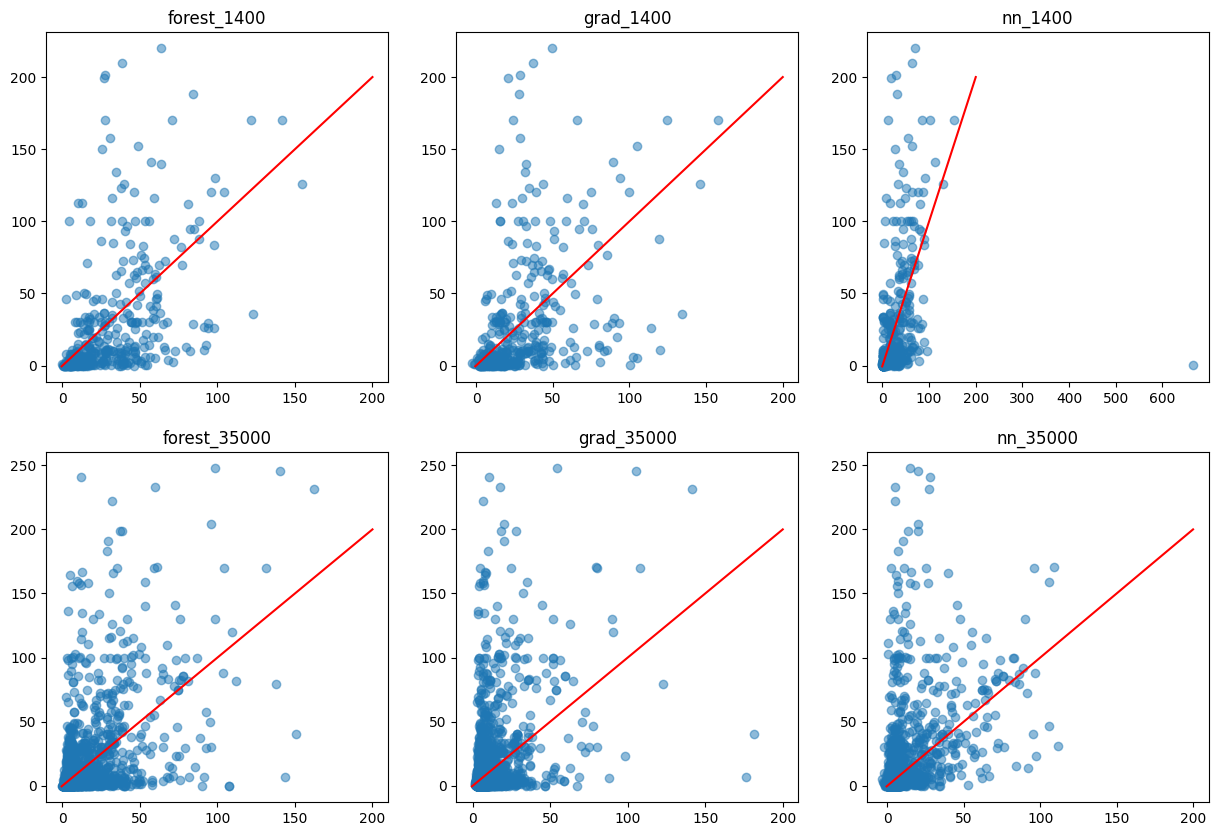

In [27]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_1400_forest).flatten(), np.array(y_test_1400.tolist()).flatten(), alpha=0.5)
plt.title("forest_1400")

plt.subplot(2, 3, 2)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_1400_grad).flatten(), np.array(y_test_1400.tolist()).flatten(), alpha=0.5)
plt.title("grad_1400")

plt.subplot(2, 3, 3)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_1400_nn.tolist()).flatten(), np.array(y_test_1400.tolist()).flatten(), alpha=0.5)
plt.title("nn_1400")

plt.subplot(2, 3, 4)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_35000_forest).flatten(), np.array(y_test_35000.tolist()).flatten(), alpha=0.5)
plt.title("forest_35000")

plt.subplot(2, 3, 5)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_35000_grad).flatten(), np.array(y_test_35000.tolist()).flatten(), alpha=0.5)
plt.title("grad_35000")

plt.subplot(2, 3, 6)
plt.plot([-0.5, 200], [-0.5, 200], color="red")
plt.scatter(np.array(y_pred_35000_nn.tolist()).flatten(), np.array(y_test_35000.tolist()).flatten(), alpha=0.5)
plt.title("nn_35000")